In [ ]:
!odsc conda install -s fspyspark32_p38_cpu_v2

In [1]:
!pip install openai==0.28 python-dotenv spacy tiktoken

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">OpenAI embeddings in feature store</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.3. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.4. Select subset of features</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#join_featuregroup'>3.6. Apply joins on feature group</a>
    - <a href='#create_dataset'>3.7. Create dataset from multiple or one feature group</a>
    - <a href='#sql_query'>3.8 Free form sql query</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg. All/subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Another way to look at it is that an entity is an object or concept that is described by its features. Examples of entities could be customer, product, transaction, review, image, document, etc.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in ml models. It serves as an organizational unit within the feature store for users to manage, version and share features across different ml projects. By organizing features into groups, data scientists and ml engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: Feature group job is the execution instance of a feature group. Each feature group job will include validation results and statistics results.

* **Dataset**: A dataset is a collection of feature that are used together to either train a model or perform model inference.

* **Dataset Job**: Dataset job is the execution instance of a dataset. Each dataset job will include validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.


<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

python -m pip install --pre oracle-ads==2.9.0rc0<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [2]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"fs_service_endpoint": "https://{api_gateway}/20230101"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [3]:
import os

compartment_id = os.environ.get("NB_SESSION_COMPARTMENT_OCID")
metastore_id = "<metastore_id>"
os.environ["OPENAI_API_KEY"] = "<OPENAI_API_KEY>"

<a id="featurestore_querying"></a>
# 3. Feature group use cases
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.

In [4]:
import warnings
warnings.filterwarnings("ignore", message="iteritems is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode


from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

In [6]:
# load & inspect dataset
import pandas as pd
input_datapath = "https://raw.githubusercontent.com/oracle-samples/oci-data-science-ai-samples/main/notebook_examples/data/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

Time   ProductId          UserId  Score  \
0  1351123200  B003XPF9BO  A3R7JR3FMEBXQB      5   
1  1351123200  B003JK537S  A3JBPC3WFUT5ZP      1   

                                                      Summary  \
0  where does one  start...and stop... with a treat like this   
1                                           Arrived in pieces   

                                                                                                                                                              Text  \
0  Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone   
1                                                      Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.   

                                                                                                                                                                                                                                      combined  
0  Title: where does one  start...and stop... with a treat like this; Content: Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone  
1                                                                                               Title: Arrived in pieces; Content: Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [7]:
feature_store_resource = (
    FeatureStore().
    with_description("Feature Store embeddings").
    with_compartment_id(compartment_id).
    with_display_name("Feature Store embeddings").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [8]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Feature Store embeddings
  displayName: Feature Store embeddings
  id: F54BD45AD710891B75645EB2CD6CE819
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxya2ipeqjr2m7npnn3kboq4s27erl3ts56wggl6ls6gpn3q
type: featureStore

#### 3.2.2 Entity
An entity is a logical segregation of feature store entities

In [9]:
entity = feature_store.create_entity(
    display_name="Feature Store embeddings",
    description="Feature Store embeddings"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Feature Store embeddings
  featureStoreId: F54BD45AD710891B75645EB2CD6CE819
  id: 5D085A5E1D1D2526228C5942C9295EB9
  name: Feature Store embeddings
type: entity

#### 3.2.3 Transformation

In [10]:
def openai_generate_embedding_data(df):
    import pandas as pd
    import tiktoken
    import openai
    import dotenv
    import os
    from ast import literal_eval
    dotenv.load_dotenv()
    openai.api_key=os.getenv("OPENAI_API_KEY")
    
    def get_embedding(text: str, engine="text-similarity-davinci-001", **kwargs):
        text = text.replace("\n", " ")
        return openai.Embedding.create(input=[text], engine=engine, **kwargs)["data"][0]["embedding"]
    
    
    # embedding model parameters
    embedding_model = "text-embedding-ada-002"
    embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
    max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
    # subsample to 1k most recent reviews and remove samples that are too long
    top_n = 1000
    df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
    df.drop("Time", axis=1, inplace=True)
    encoding = tiktoken.get_encoding(embedding_encoding)
    df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
    df = df[df.n_tokens <= max_tokens].tail(top_n)
    df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
    return df

In [11]:
from ads.feature_store.transformation import TransformationMode

embedding_transformation = feature_store.create_transformation(
    transformation_mode=TransformationMode.PANDAS,
    source_code_func=openai_generate_embedding_data,
    display_name="openai_generate_embedding_data",
)

embedding_transformation


kind: transformation
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  displayName: openai_generate_embedding_data
  featureStoreId: F54BD45AD710891B75645EB2CD6CE819
  id: 8E53096588C1171042195FE62576EDC3
  sourceCode: ZGVmIG9wZW5haV9nZW5lcmF0ZV9lbWJlZGRpbmdfZGF0YShkZik6CiAgICBpbXBvcnQgcGFuZGFzIGFzIHBkCiAgICBpbXBvcnQgdGlrdG9rZW4KICAgIGltcG9ydCBvcGVuYWkKICAgIGltcG9ydCBkb3RlbnYKICAgIGltcG9ydCBvcwogICAgZnJvbSBhc3QgaW1wb3J0IGxpdGVyYWxfZXZhbAogICAgZG90ZW52LmxvYWRfZG90ZW52KCkKICAgIG9wZW5haS5hcGlfa2V5PW9zLmdldGVudigiT1BFTkFJX0FQSV9LRVkiKQogICAgCiAgICBkZWYgZ2V0X2VtYmVkZGluZyh0ZXh0OiBzdHIsIGVuZ2luZT0idGV4dC1zaW1pbGFyaXR5LWRhdmluY2ktMDAxIiwgKiprd2FyZ3MpOgogICAgICAgIHRleHQgPSB0ZXh0LnJlcGxhY2UoIlxuIiwgIiAiKQogICAgICAgIHJldHVybiBvcGVuYWkuRW1iZWRkaW5nLmNyZWF0ZShpbnB1dD1bdGV4dF0sIGVuZ2luZT1lbmdpbmUsICoqa3dhcmdzKVsiZGF0YSJdWzBdWyJlbWJlZGRpbmciXQogICAgCiAgICAKICAgICMgZW1iZWRkaW5nIG1vZGVsIHBhcmFtZXRlcnMKICAgIGVtYmVkZGluZ19tb2RlbCA9ICJ0ZXh0LWVtYmVkZ

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_flights"></a>
##### Open AI feature Group

Create feature group for Open AI Feature Group

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_group_flights.gif" width="700" height="350" />
</div>

In [12]:
embedding_feature_group = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys([])
    .with_name("embedding_fg")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(df)
    .with_transformation_id(embedding_transformation.id)
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/12/11 06:27:49 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



In [13]:
embedding_feature_group.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 5D085A5E1D1D2526228C5942C9295EB9
  featureStoreId: F54BD45AD710891B75645EB2CD6CE819
  id: 470A7AD53BC6F20F5507F4D2E677B6B5
  inputFeatureDetails:
  - featureType: LONG
    name: Time
    orderNumber: 1
  - featureType: STRING
    name: ProductId
    orderNumber: 2
  - featureType: STRING
    name: UserId
    orderNumber: 3
  - featureType: LONG
    name: Score
    orderNumber: 4
  - featureType: STRING
    name: Summary
    orderNumber: 5
  - featureType: STRING
    name: Text
    orderNumber: 6
  - featureType: STRING
    name: combined
    orderNumber: 7
  isInferSchema: true
  name: embedding_fg
  primaryKeys:
    items: []
  statisticsConfig:
    isEnabled: true
  transformationId: 8E53096588C1171042195FE62576EDC3
  transformationParameters: e30=
type: featureGroup

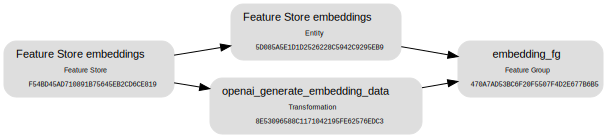

In [14]:
embedding_feature_group.show()

In [15]:
embedding_feature_group.materialise(df)

Hive Session ID = 245bb83c-b040-43b7-8510-684ca7b8848b


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



  logger.warn("Reference profile is empty")

INFO:ads.feature_store.common.utils.utility:Ingestion Summary 
╒══════════════════════════════════╤═══════════════╤════════════════════╤═════════════════╕
│            entity_id             │  entity_type  │  ingestion_status  │  error_details  │
╞══════════════════════════════════╪═══════════════╪════════════════════╪═════════════════╡
│ 470A7AD53BC6F20F5507F4D2E677B6B5 │ FEATURE_GROUP │     Succeeded      │      None       │
╘══════════════════════════════════╧═══════════════╧════════════════════╧═════════════════╛


<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups


distutils Version classes are deprecated. Use packaging.version instead.




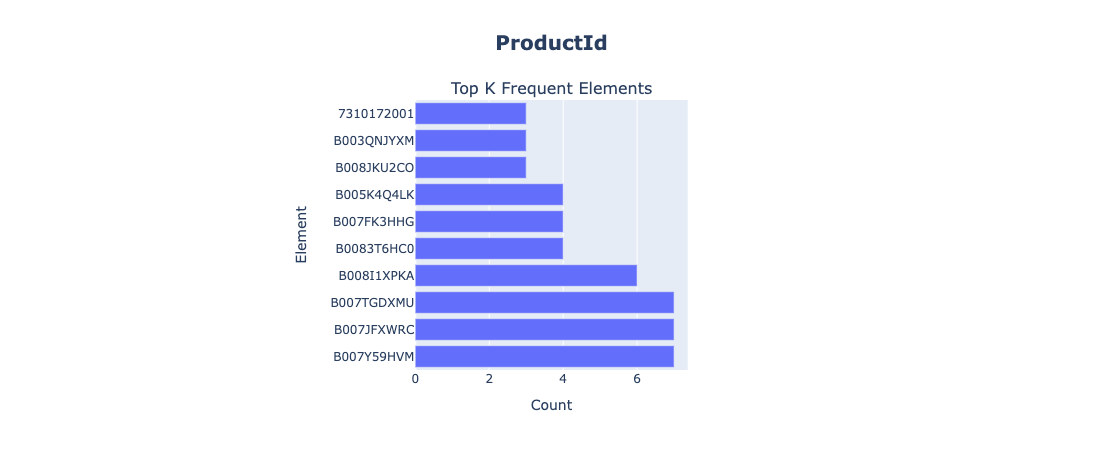

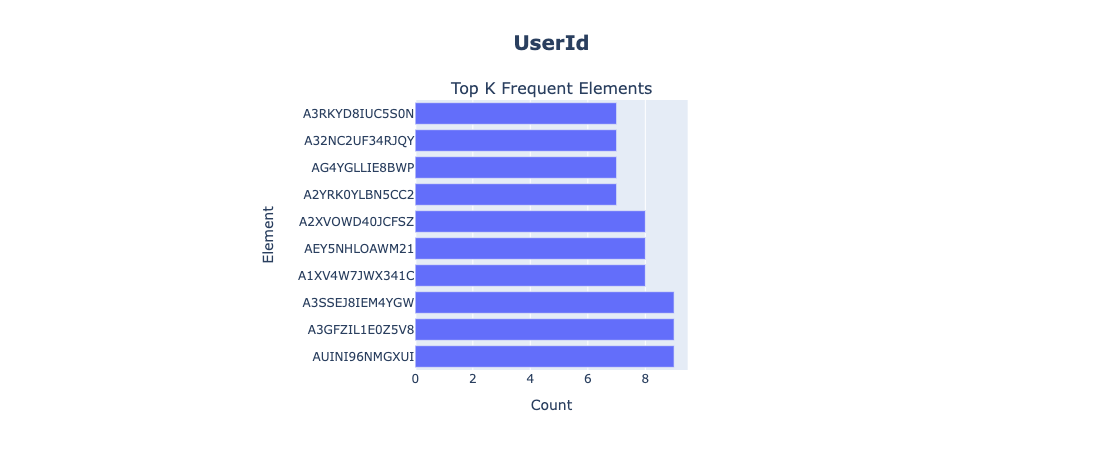

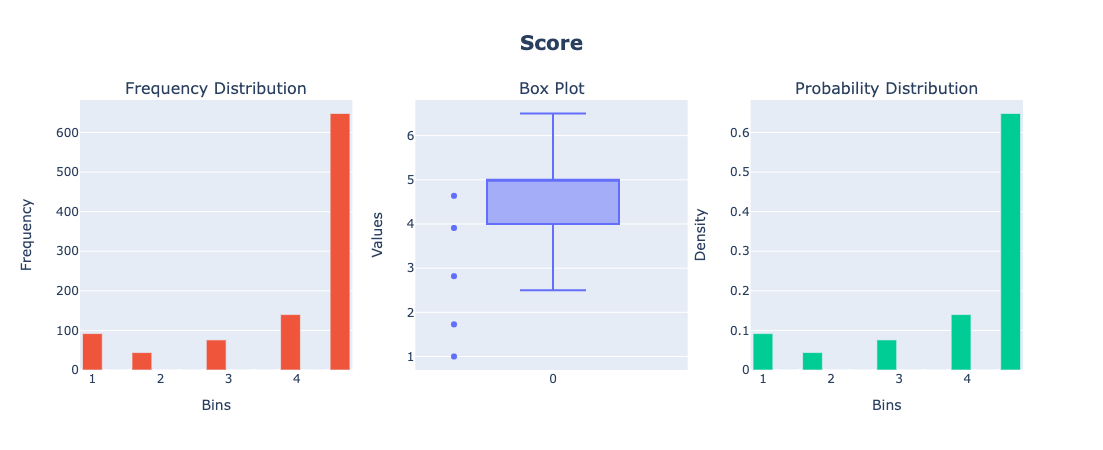

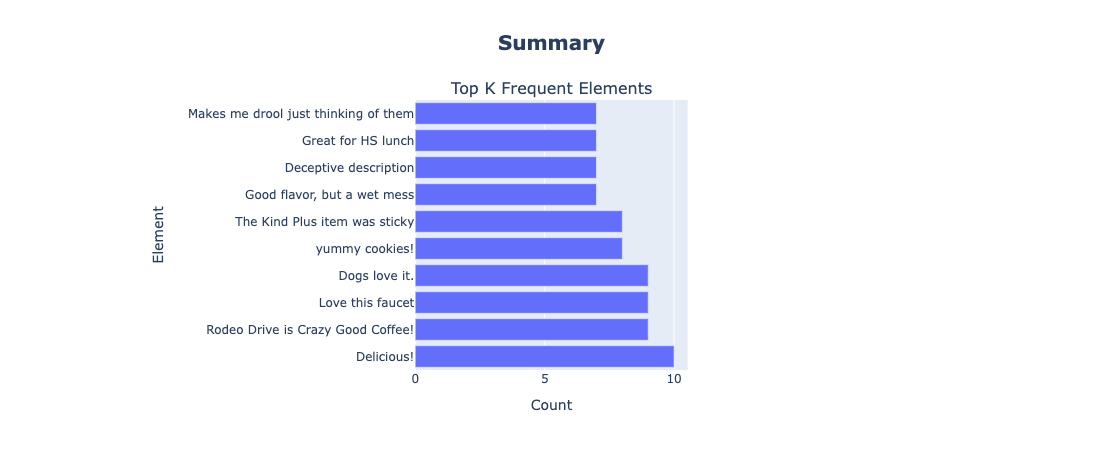

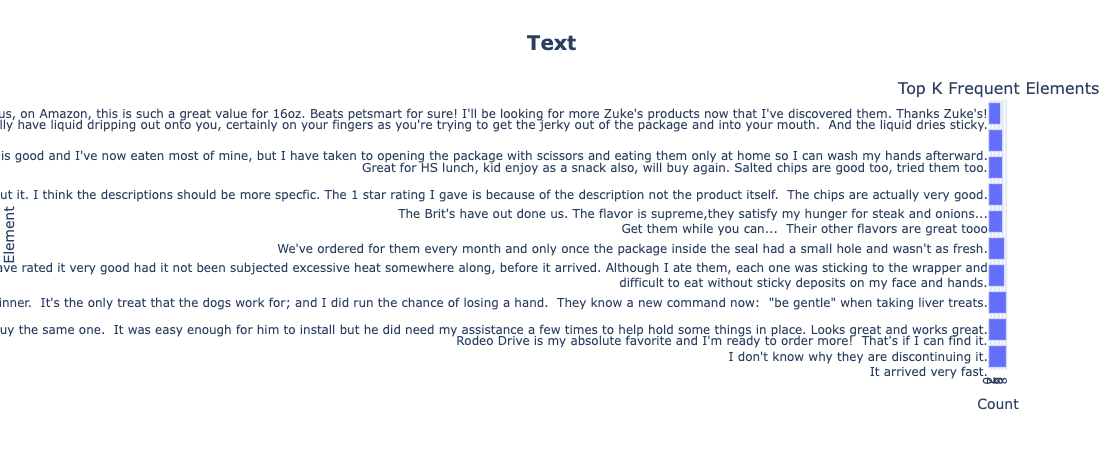

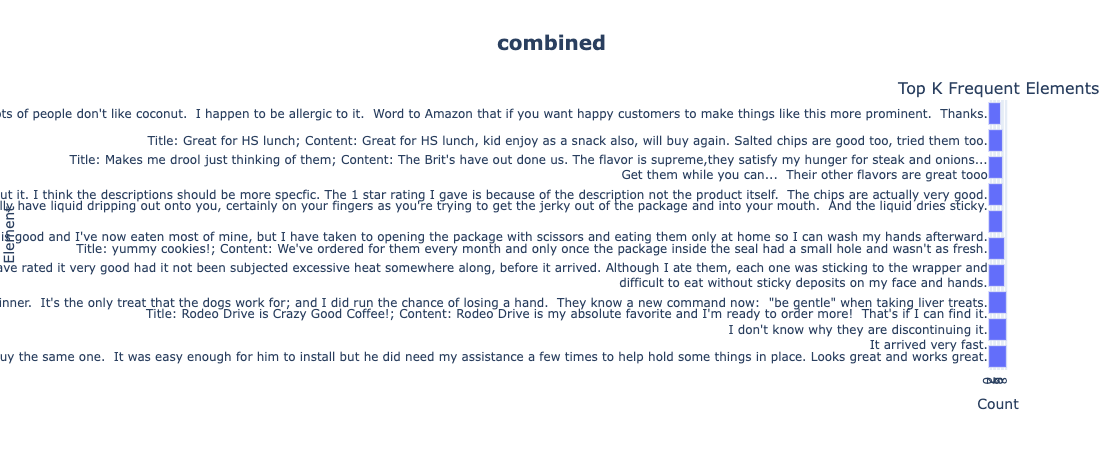

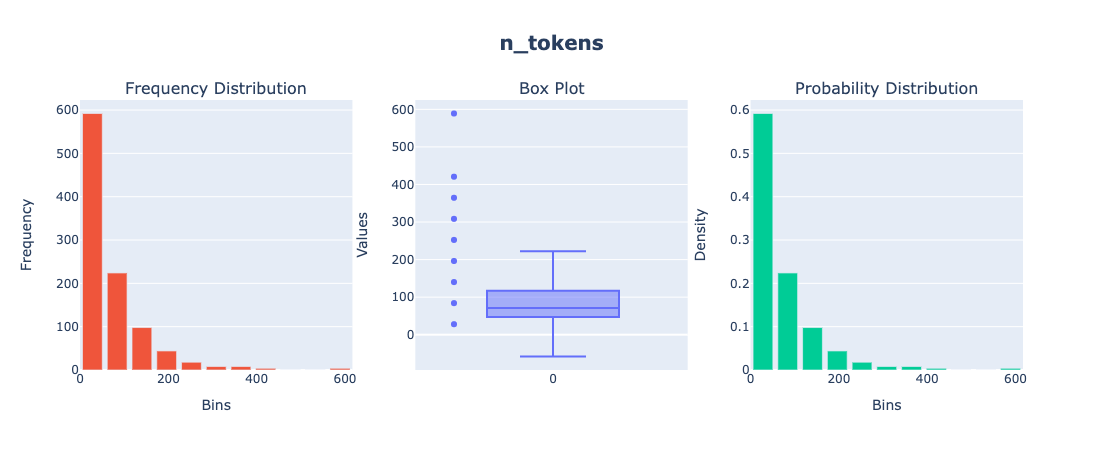

In [16]:
embedding_feature_group.get_statistics().to_viz()

In [17]:
embedding_feature_group.history().show()

+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|          timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2023-12-11 06:30:52|  null|    null|CREATE OR REPLACE...|{isManaged -> tru...|null|    null|     null|       null|  Serializable|        false|{numFiles -> 2, n...|        null|Apache-Spark/3.2....|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+----------------

In [18]:
embedding_feature_group.as_of(version_number=0).show()

+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
| ProductId|        UserId|Score|             Summary|                Text|            combined|n_tokens|           embedding|
+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
|B003XPF9BO|A3R7JR3FMEBXQB|    5|where does one  s...|Wanted to save so...|Title: where does...|      52|[0.00706059299409...|
|B003VXHGPK|A21VWSCGW7UUAR|    4|Good, but not Wol...|Honestly, I have ...|Title: Good, but ...|     178|[-0.0033068784978...|
|B008JKTTUA|A34XBAIFT02B60|    1|Should advertise ...|First, these shou...|Title: Should adv...|      78|[-0.0175583828240...|
|B000LKTTTW|A14MQ40CCU8B13|    5|    Best tomato soup|I have a hard tim...|Title: Best tomat...|     111|[-0.0013923920923...|
|B001D09KAM|A34XBAIFT02B60|    1|Should advertise ...|First, these shou...|Title: Should adv...|      78|[-0.01

In [19]:
embedding_feature_group.get_features_df()

name          type
0  ProductId        STRING
1     UserId        STRING
2      Score          LONG
3    Summary        STRING
4       Text        STRING
5   combined        STRING
6   n_tokens          LONG
7  embedding  DOUBLE_ARRAY

In [20]:
embedding_feature_group.get_validation_output().to_pandas()

In [21]:
embedding_feature_group.select().show()

+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
| ProductId|        UserId|Score|             Summary|                Text|            combined|n_tokens|           embedding|
+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
|B003XPF9BO|A3R7JR3FMEBXQB|    5|where does one  s...|Wanted to save so...|Title: where does...|      52|[0.00706059299409...|
|B003VXHGPK|A21VWSCGW7UUAR|    4|Good, but not Wol...|Honestly, I have ...|Title: Good, but ...|     178|[-0.0033068784978...|
|B008JKTTUA|A34XBAIFT02B60|    1|Should advertise ...|First, these shou...|Title: Should adv...|      78|[-0.0175583828240...|
|B000LKTTTW|A14MQ40CCU8B13|    5|    Best tomato soup|I have a hard tim...|Title: Best tomat...|     111|[-0.0013923920923...|
|B001D09KAM|A34XBAIFT02B60|    1|Should advertise ...|First, these shou...|Title: Should adv...|      78|[-0.01

<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

In [22]:
embedding_feature_group.select(['UserId', 'Summary']).show()

+--------------+--------------------+
|        UserId|             Summary|
+--------------+--------------------+
|A3R7JR3FMEBXQB|where does one  s...|
|A21VWSCGW7UUAR|Good, but not Wol...|
|A34XBAIFT02B60|Should advertise ...|
|A14MQ40CCU8B13|    Best tomato soup|
|A34XBAIFT02B60|Should advertise ...|
|A1XV4W7JWX341C|Loved these glute...|
|A3ESIUM1JTR7KK|These fresh berri...|
|A1UW65ZMZ3UWD3|          Baconnaise|
|A1XV4W7JWX341C|Loved these glute...|
| AXG287OY16WWL|                Cute|
+--------------+--------------------+
only showing top 10 rows



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [39]:
embedding_feature_group.filter(embedding_feature_group.UserId == "A3R7JR3FMEBXQB").show()

+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
| ProductId|        UserId|Score|             Summary|                Text|            combined|n_tokens|           embedding|
+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+
|B003XPF9BO|A3R7JR3FMEBXQB|    5|where does one  s...|Wanted to save so...|Title: where does...|      52|[0.00706059299409...|
+----------+--------------+-----+--------------------+--------------------+--------------------+--------+--------------------+



In [40]:
tranining_df = embedding_feature_group.select().read().toPandas()
tranining_df.head()


distutils Version classes are deprecated. Use packaging.version instead.



distutils Version classes are deprecated. Use packaging.version instead.




ProductId          UserId  Score  \
0  B003XPF9BO  A3R7JR3FMEBXQB      5   
1  B003VXHGPK  A21VWSCGW7UUAR      4   
2  B008JKTTUA  A34XBAIFT02B60      1   
3  B000LKTTTW  A14MQ40CCU8B13      5   
4  B001D09KAM  A34XBAIFT02B60      1   

                                                      Summary  \
0  where does one  start...and stop... with a treat like this   
1                            Good, but not Wolfgang Puck good   
2  Should advertise coconut as an ingredient more prominently   
3                                            Best tomato soup   
4  Should advertise coconut as an ingredient more prominently   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone   
1  Honestly, I have to admit that I expected a little better. That's not to say that this is bad coffee - in fact it's quite bold without being too acidic, and pretty satisfying overall. I think my main problem is that Wolfgang Puck's name is attached to it, so perhaps it set my expectations a little high. I have a Wolfgang Puck knife set that I adore, and is very high quality for what I paid for it. This coffee was on sale, so it was well worth it also, I just hoped for something that would knock my socks off - which it didn't. I also purchased the Breakfast blend, and Jamaica me crazy at the same time. The breakfast blend was the best, in my opinion, and the jamaican coffee smelled the best, but was the least successful.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                          First, these should be called Mac - Coconut bars, as Coconut is the #2 ingredient and Mango is #3.  Second, lots of people don't like coconut.  I happen to be allergic to it.  Word to Amazon that if you want happy customers to make things like this more prominent.  Thanks.   
3                                                                                                                                                                                                                                                                                              I have a hard time finding packaged food of any type, without dairy in it; even potato chips these days have it. The Imagine Organic is just 

<a id="visualise_embeddings"></a>
### 3.5. Visualise embeddings

In [41]:
tranining_df['embedding'] = tranining_df['embedding'].apply(lambda x: [float(val) for val in x])

In [42]:
tranining_df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

In [43]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(literal_eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7febf02b8dc0>
Traceback (most recent call last):
  File "/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


(1000, 2)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

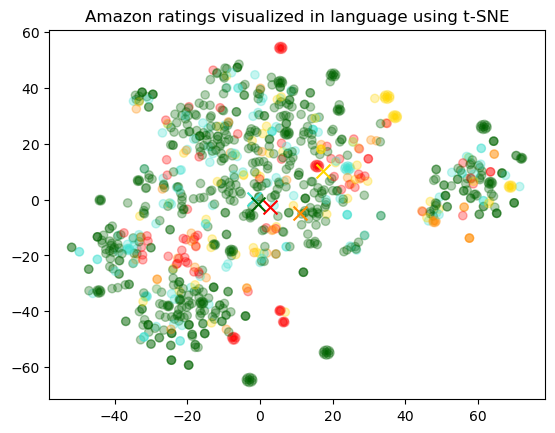

In [44]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

In this text classification task, we predict the score of a food review (1 to 5) based on the embedding of the review's text. We split the dataset into a training and a testing set for all the following tasks, so we can realistically evaluate performance on unseen data. 

In [45]:
# imports
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.Score, test_size=0.2, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           1       1.00      0.35      0.52        20
           2       1.00      0.38      0.55         8
           3       1.00      0.18      0.31        11
           4       1.00      0.26      0.41        27
           5       0.74      1.00      0.85       134

    accuracy                           0.77       200
   macro avg       0.95      0.43      0.53       200
weighted avg       0.83      0.77      0.72       200



In [47]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_multiclass_precision_recall(
    y_score, y_true_untransformed, class_list, classifier_name
):
    """
    Precision-Recall plotting for a multiclass problem. It plots average precision-recall, per class precision recall and reference f1 contours.

    Code slightly modified, but heavily based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    n_classes = len(class_list)
    y_true = pd.concat(
        [(y_true_untransformed == class_list[i]) for i in range(n_classes)], axis=1
    ).values

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision_micro, recall_micro, _ = precision_recall_curve(
        y_true.ravel(), y_score.ravel()
    )
    average_precision_micro = average_precision_score(y_true, y_score, average="micro")
    print(
        str(classifier_name)
        + " - Average precision score over all classes: {0:0.2f}".format(
            average_precision_micro
        )
    )

    # setup plot details
    plt.figure(figsize=(9, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append("iso-f1 curves")
    (l,) = plt.plot(recall_micro, precision_micro, color="gold", lw=2)
    lines.append(l)
    labels.append(
        "average Precision-recall (auprc = {0:0.2f})" "".format(average_precision_micro)
    )

    for i in range(n_classes):
        (l,) = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append(
            "Precision-recall for class `{0}` (auprc = {1:0.2f})"
            "".format(class_list[i], average_precision[i])
        )

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{classifier_name}: Precision-Recall curve for each class")
    plt.legend(lines, labels)

RandomForestClassifier() - Average precision score over all classes: 0.87


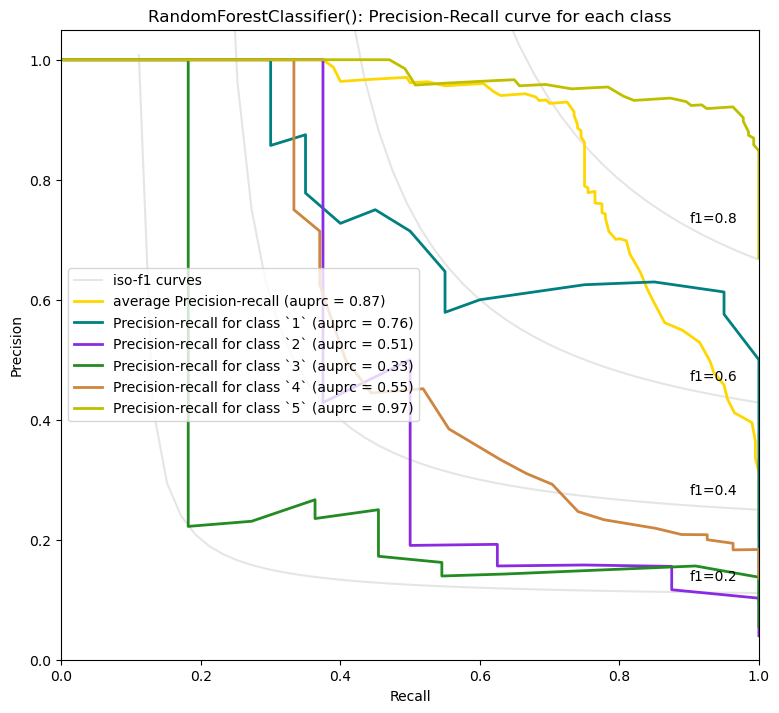

In [48]:
plot_multiclass_precision_recall(probas, y_test, [1, 2, 3, 4, 5], clf)

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)